# 1. Intro

EDA of X-ray images of lungs



# 2. Import libraries

In [6]:
# !pip install albumentations

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import os

# To retrieve files/pathnames matching a specified pattern
import glob

# For adding progress bar
from tqdm.notebook import tqdm

# For image augmentation  to increase the quality of trained models
import albumentations as A

from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [7]:
# Plot multiple images
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title=""):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=3, ncols=ncols, squeeze=False)
    
    # 1. Add a centered title to the figure
    fig.suptitle(main_title, fontsize = 30)
    # 2. wspace : This parameter is the amount of width reserved for space between subplots expressed as
    # a fraction of the average axis width.
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()

In [10]:
# Look at the training, testing and validation data numbers
train_data = glob.glob('../chest_xray/train/**/*.jpeg')
test_data = glob.glob('../chest_xray/test/**/*.jpeg')
val_data = glob.glob('../chest_xray/val/**/*.jpeg')

print(f"Training Set has: {len(train_data)} images")
print(f"Testing Set has: {len(test_data)} images")
print(f"Validation Set has: {len(val_data)} images")



Training Set has: 5216 images
Testing Set has: 624 images
Validation Set has: 16 images


In [12]:
# Check Peneuymania vs normal images distribution
DIR = "../chest_xray/"
sets = ["train", "test", "val"]
all_pneumonia = []
all_normal = []

for cat in sets:
    path = os.path.join(DIR, cat)
    norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)

print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")

Total Pneumonia Images: 4273
Total Normal Images: 1583


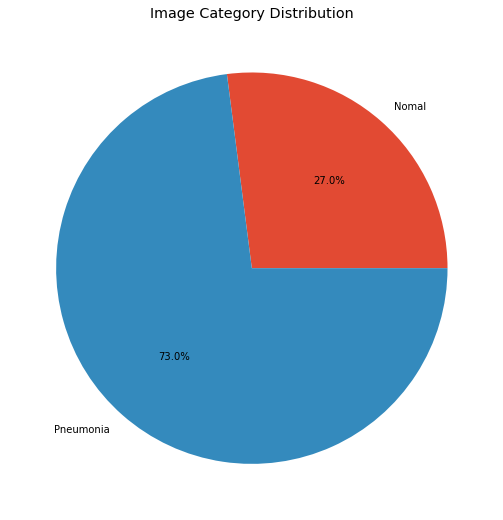

In [13]:
labels = ['Nomal', 'Pneumonia']
targets = [len(all_normal), len(all_pneumonia)]

plt.style.use("ggplot")
plt.figure(figsize=(16, 9))
plt.pie(x=targets, labels=labels, autopct="%1.1f%%")
plt.title("Image Category Distribution")
plt.show()


# 3. EDA

In [14]:
# Shuffle list of images
random.shuffle(all_normal)
random.shuffle(all_pneumonia)
images = all_normal[:50] + all_pneumonia[:50]

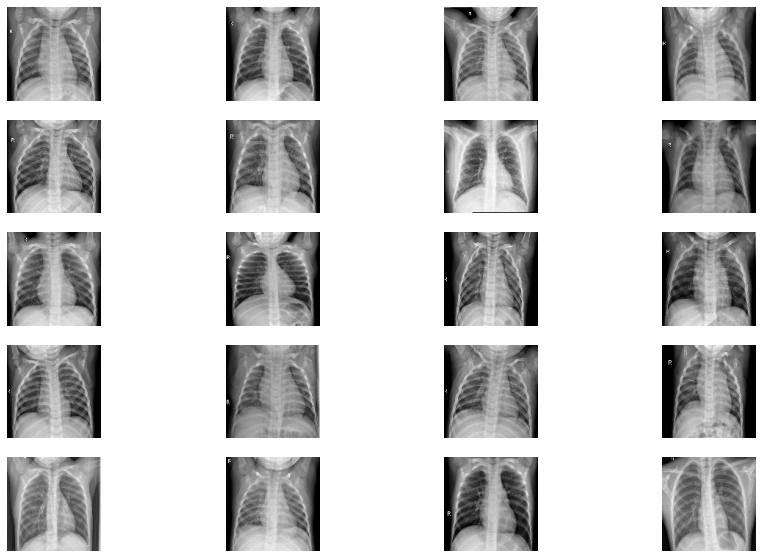

In [15]:
# Show images
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 5

for i in range(1, columns*rows +1):
    # read img
    img = cv2.imread(images[i])
    
    # resize image
    img = cv2.resize(img, (128, 128))
    fig.add_subplot(rows, columns, i)
    
    # show
    plt.imshow(img)
    plt.axis(False)



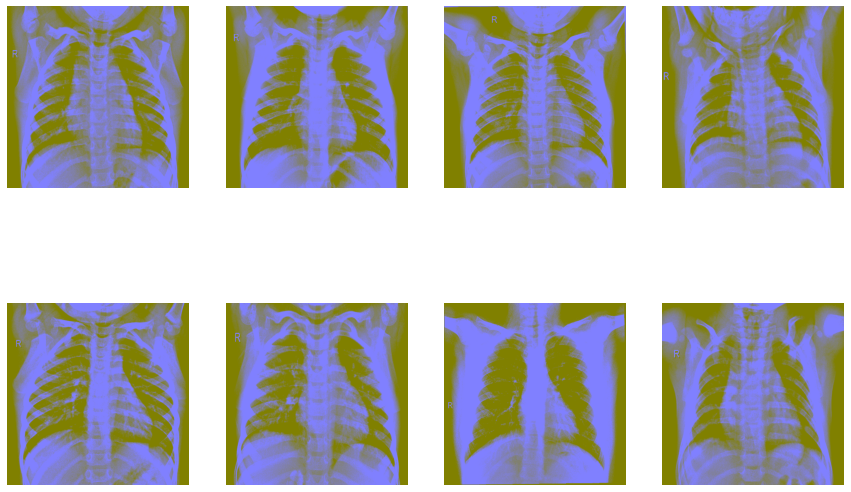

In [16]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

## 3.1 Fourier Method for Pixel Distribution

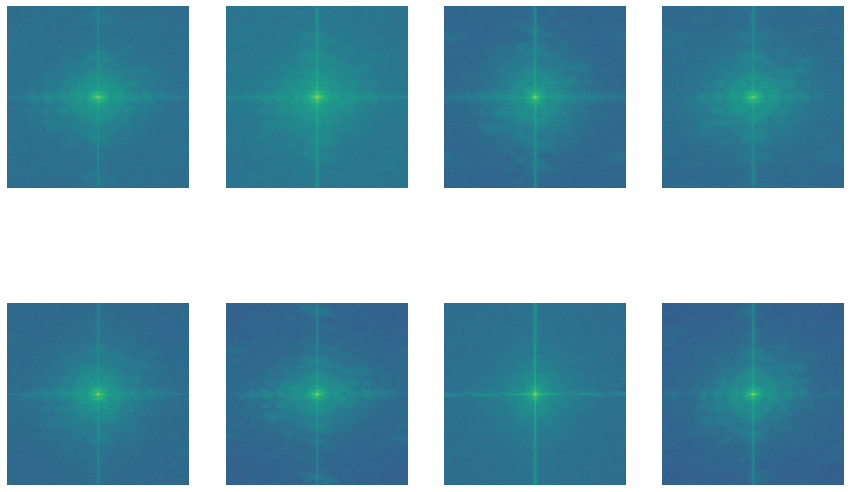

In [17]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    fig.add_subplot(rows, columns, i)
    plt.imshow(magnitude_spectrum)
    plt.axis(False)

## 3.2 Albumentations

/Users/sherlyhartono/opt/anaconda3/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1699: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/Users/sherlyhartono/opt/anaconda3/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1725: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


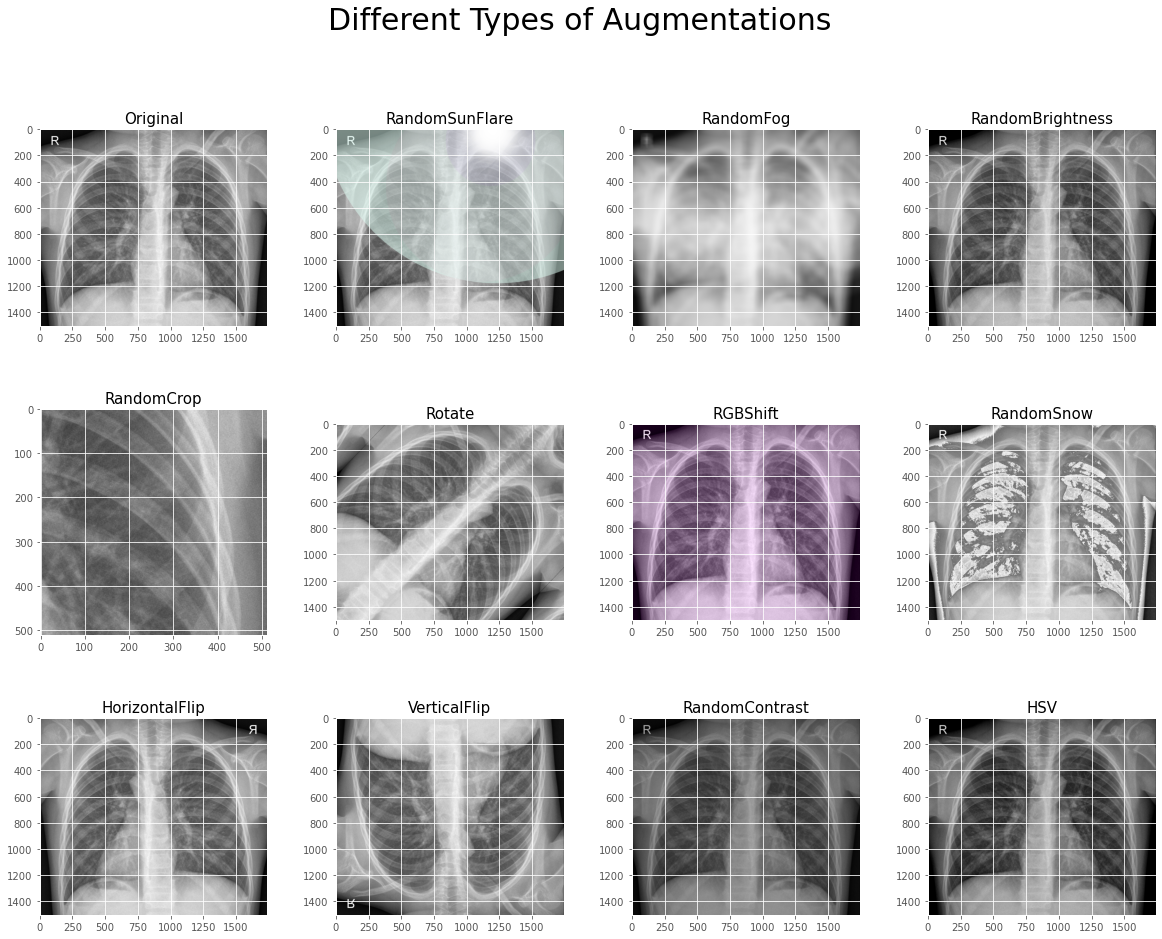

In [18]:
chosen_image = cv2.imread(images[25])
albumentation_list = [A.RandomSunFlare(p=1), A.RandomFog(p=1), A.RandomBrightness(p=1),
                      A.RandomCrop(p=1,height = 512, width = 512), A.Rotate(p=1, limit=90),
                      A.RGBShift(p=1), A.RandomSnow(p=1),
                      A.HorizontalFlip(p=1), A.VerticalFlip(p=1), A.RandomContrast(limit = 0.5,p = 1),
                      A.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50)]

img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)

img_matrix_list.insert(0,chosen_image)    

titles_list = ["Original","RandomSunFlare","RandomFog","RandomBrightness",
               "RandomCrop","Rotate", "RGBShift", "RandomSnow","HorizontalFlip", "VerticalFlip", "RandomContrast","HSV"]

plot_multiple_img(img_matrix_list, titles_list, ncols = 4,main_title="Different Types of Augmentations")

# 3.3 Image Dilation

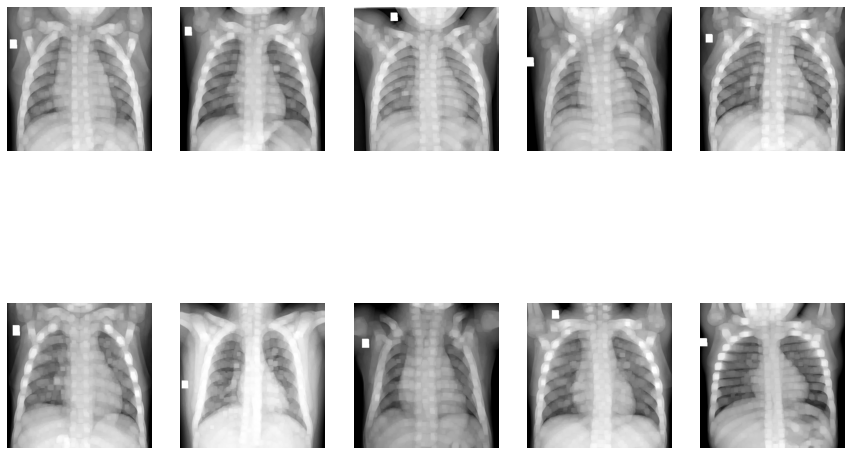

In [19]:


fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.dilate(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_erosion)
    plt.axis(False)



# 3.4 Canny Edge Detection

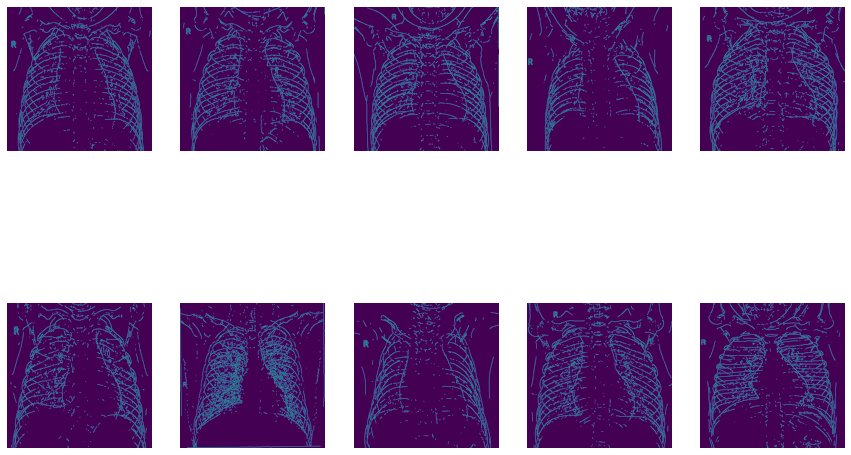

In [20]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(edges)
    plt.axis(False)